## Description about this notebook
This notebook is designed to visually compare the performance of our three different YOLO NAS models (Small, Medium, Large) in terms of two key metrics: Mean Average Precision at 50% (MAP50) and Mean Average Precision from 50% to 95% (MAP50:95). We employed a supervision function for this evaluation. The assessment was carried out on a test dataset, which was not previously exposed to the models. This test dataset is unique as it comprises a new blend of Jersey and Holstein cow images, captured from two distinct camera perspectives: top and side views. This setup ensures a comprehensive evaluation of the models' ability to accurately detect and recognize objects in varied and realistic scenarios.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING to ignore INFO messages
logging.basicConfig(level=logging.WARNING)

import os
os.environ['TORCH_HOME'] = '/home/mautushid/.torch'

#from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/home/mautushid/Cowsformer


In [2]:
from models.nas import *
import pandas as pd
import matplotlib.pyplot as plt

The console stream is logged into /home/mautushid/sg_logs/console.log


[2024-02-15 13:25:31] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-15 13:25:31] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-15 13:25:33] WARNING - __init__.py - Matplotlib created a temporary cache directory at /localscratch/2081073/matplotlib-whzjmwb6 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[2024-02-15 13:25:34] INFO - font_manager.py - generated new fontManager
[2024-02-15 13:25:37] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-15 13:25:37] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-15 13:25:37] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:

# Directory containing all the checkpoints
checkpoints_dir = ROOT + "/checkpoints_breed"

# Function to sort and organize checkpoint paths into the specified format
def organize_checkpoints_corrected(checkpoints_dir):
    # Dictionary to hold the paths categorized by category, then by type
    categorized_paths = {}

    # Iterate through each subdirectory in the checkpoints directory
    for sub_dir in os.listdir(checkpoints_dir):
        # Construct the full path of the subdirectory
        full_sub_dir_path = os.path.join(checkpoints_dir, sub_dir)
        # Check if the current path is a directory
        if os.path.isdir(full_sub_dir_path):
            # Extract category, iteration, and type from the folder name
            parts = sub_dir.split('_')
            category = parts[0]  # e.g., n10
            size_type = parts[-3][-1]  # Assuming type is represented by the last letter before the category and iteration

            # Validate size_type to be 's', 'm', or 'l'
            if size_type not in ['s', 'm', 'l']:
                continue  # Skip if size_type does not match expected values
            
            # Iterate through the RUN_... directory inside the current subdirectory
            for run_dir in os.listdir(full_sub_dir_path):
                run_dir_path = os.path.join(full_sub_dir_path, run_dir)
                if os.path.isdir(run_dir_path):
                    # Construct the path to the ckpt_best.pth file inside the RUN_... directory
                    ckpt_path = os.path.join(run_dir_path, 'ckpt_best.pth')
                    if os.path.exists(ckpt_path):
                        # Initialize the nested dictionaries and lists as needed
                        if category not in categorized_paths:
                            categorized_paths[category] = {'s': [], 'm': [], 'l': []}
                        categorized_paths[category][size_type].append(ckpt_path)

    # Sort paths within each list
    for category in categorized_paths.keys():
        for size_type in categorized_paths[category].keys():
            categorized_paths[category][size_type].sort()

    return categorized_paths

# Call the function and print the organized checkpoint paths
organized_paths = organize_checkpoints_corrected(checkpoints_dir)
for category, types in organized_paths.items():
    print(f"{category}:")
    for size_type, paths in types.items():
        print(f"  {size_type}:")
        for path in paths:
            print(f"    {path}")


n100:
  s:
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i1_exp_yolo_nas_s_100_1/RUN_20240208_031031_042286/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i2_exp_yolo_nas_s_100_2/RUN_20240208_095332_321300/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i3_exp_yolo_nas_s_100_3/RUN_20240208_170808_999241/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i4_exp_yolo_nas_s_100_4/RUN_20240209_003607_035968/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i5_exp_yolo_nas_s_100_5/RUN_20240209_081721_694681/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i6_exp_yolo_nas_s_100_6/RUN_20240209_151823_199756/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i7_exp_yolo_nas_s_100_7/RUN_20240209_223716_400965/ckpt_best.pth
    /home/mautushid/Cowsformer/checkpoints_breed/n100_yolo_na_i8_exp_yolo_nas_s_100_8/RUN_20240210_0

In [4]:
n10_s_path = organized_paths['n10']['s']
n10_m_path = organized_paths['n10']['m']
n10_l_path = organized_paths['n10']['l']

n25_s_path = organized_paths['n200']['s']
n25_m_path = organized_paths['n200']['m']
n25_l_path = organized_paths['n200']['l']

n50_s_path = organized_paths['n200']['s']
n50_m_path = organized_paths['n200']['m']
n50_l_path = organized_paths['n200']['l']

n100_s_path = organized_paths['n200']['s']
n100_m_path = organized_paths['n200']['m']
n100_l_path = organized_paths['n200']['l']

n200_s_path = organized_paths['n200']['s']
n200_m_path = organized_paths['n200']['m']
n200_l_path = organized_paths['n200']['l']

In [5]:
path_model_s = 'yolo_nas_s'
path_model_m = 'yolo_nas_m'
path_model_l = 'yolo_nas_l'
dir_train = "/home/mautushid/Cowsformer/data/breed/train"
dir_val = "/home/mautushid/Cowsformer/data/breed/val"
dir_test = "/home/mautushid/Cowsformer/data/breed/test"
name_task = "breed"
data_yaml_path = "/home/mautushid/Cowsformer/data/breed/data.yaml"

def evaluate_models_s(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_s, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_s, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_m(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_m, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_m, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_l(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_l, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_l, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

In [6]:
evaluattion_results_n10_s_path = evaluate_models_s(n10_s_path)
evaluattion_results_n10_m_path = evaluate_models_m(n10_m_path)
evaluattion_results_n10_l_path = evaluate_models_l(n10_l_path)

evaluattion_results_n25_s_path = evaluate_models_s(n25_s_path)
evaluattion_results_n25_m_path = evaluate_models_m(n25_m_path)
evaluattion_results_n25_l_path = evaluate_models_l(n25_l_path)

evaluattion_results_n50_s_path = evaluate_models_s(n50_s_path)
evaluattion_results_n50_m_path = evaluate_models_m(n50_m_path)
evaluattion_results_n50_l_path = evaluate_models_l(n50_l_path)

evaluattion_results_n100_s_path = evaluate_models_s(n100_s_path)
evaluattion_results_n100_m_path = evaluate_models_m(n100_m_path)
evaluattion_results_n100_l_path = evaluate_models_l(n100_l_path)

evaluattion_results_n200_s_path = evaluate_models_s(n200_s_path)
evaluattion_results_n200_m_path = evaluate_models_m(n200_m_path)
evaluattion_results_n200_l_path = evaluate_models_l(n200_l_path)

[2024-02-15 13:25:38] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-15 13:25:38] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-15 13:25:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i1_exp_yolo_nas_s_10_1/RUN_20240207_230557_230082/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i2_exp_yolo_nas_s_10_2/RUN_20240208_055127_814659/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i3_exp_yolo_nas_s_10_3/RUN_20240208_124409_189617/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i4_exp_yolo_nas_s_10_4/RUN_20240208_195853_295825/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i5_exp_yolo_nas_s_10_5/RUN_20240209_034220_760214/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i6_exp_yolo_nas_s_10_6/RUN_20240209_111143_330032/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i7_exp_yolo_nas_s_10_7/RUN_20240209_181242_642337/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i8_exp_yolo_nas_s_10_8/RUN_20240210_012932_686568/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:25:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:25:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:25:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:25:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:25:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:25:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:25:48] INFO -

[2024-02-15 13:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:17] INFO -

[2024-02-15 13:26:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:30] INFO -

[2024-02-15 13:26:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:26:58] INFO -

[2024-02-15 13:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:24] INFO -

[2024-02-15 13:27:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:27:56] INFO -

[2024-02-15 13:28:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:11] INFO -

[2024-02-15 13:28:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:28:32] INFO -

model yolo_nas_m loaded


[2024-02-15 13:28:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i2_exp_yolo_nas_m_10_2/RUN_20240208_060744_061478/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:04] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i3_exp_yolo_nas_m_10_3/RUN_20240208_130129_875451/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i4_exp_yolo_nas_m_10_4/RUN_20240208_201552_062449/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i5_exp_yolo_nas_m_10_5/RUN_20240209_035950_574032/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i6_exp_yolo_nas_m_10_6/RUN_20240209_112728_999871/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i7_exp_yolo_nas_m_10_7/RUN_20240209_182919_245392/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i8_exp_yolo_nas_m_10_8/RUN_20240210_014528_441682/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:29:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:29] INFO -

[2024-02-15 13:29:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:29:58] INFO -

[2024-02-15 13:30:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:16] INFO -

[2024-02-15 13:30:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:36] INFO -

[2024-02-15 13:30:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:30:55] INFO -

[2024-02-15 13:31:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:11] INFO -

[2024-02-15 13:31:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:28] INFO -

[2024-02-15 13:31:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:31:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:32:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:32:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:32:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:32:03] INFO -

model yolo_nas_l loaded


[2024-02-15 13:32:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i2_exp_yolo_nas_l_10_2/RUN_20240208_063649_468999/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:32:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i3_exp_yolo_nas_l_10_3/RUN_20240208_133216_655515/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:32:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i4_exp_yolo_nas_l_10_4/RUN_20240208_204715_016637/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:33:04] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i5_exp_yolo_nas_l_10_5/RUN_20240209_043417_693711/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:33:10] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i6_exp_yolo_nas_l_10_6/RUN_20240209_115808_872395/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:33:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i7_exp_yolo_nas_l_10_7/RUN_20240209_190256_387345/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:33:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n10_yolo_na_i8_exp_yolo_nas_l_10_8/RUN_20240210_021652_657045/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:33:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:24] INFO -

[2024-02-15 13:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:33:46] INFO -

[2024-02-15 13:34:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:08] INFO -

[2024-02-15 13:34:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:34:29] INFO -

[2024-02-15 13:35:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:25] INFO -

[2024-02-15 13:35:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:35:55] INFO -

[2024-02-15 13:36:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:22] INFO -

[2024-02-15 13:36:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:36:49] INFO -

model yolo_nas_s loaded


[2024-02-15 13:37:20] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:37:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:37:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:37:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:37:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:37:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:37:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:37:35] INFO -

[2024-02-15 13:37:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:03] INFO -

[2024-02-15 13:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:27] INFO -

[2024-02-15 13:38:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:39] INFO -

[2024-02-15 13:38:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:38:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:01] INFO -

[2024-02-15 13:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:15] INFO -

[2024-02-15 13:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:39:30] INFO -

[2024-02-15 13:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:06] INFO -

model yolo_nas_m loaded


[2024-02-15 13:40:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:40:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:40:55] INFO -

[2024-02-15 13:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:12] INFO -

[2024-02-15 13:41:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:35] INFO -

[2024-02-15 13:41:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:41:52] INFO -

[2024-02-15 13:42:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:12] INFO -

[2024-02-15 13:42:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:42:46] INFO -

[2024-02-15 13:43:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:11] INFO -

[2024-02-15 13:43:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:43:30] INFO -

model yolo_nas_l loaded


[2024-02-15 13:43:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:43:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:44:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:44:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:44:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:44:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:44:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:28] INFO -

[2024-02-15 13:44:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:44:49] INFO -

[2024-02-15 13:45:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:11] INFO -

[2024-02-15 13:45:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:45:38] INFO -

[2024-02-15 13:46:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:02] INFO -

[2024-02-15 13:46:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:32] INFO -

[2024-02-15 13:46:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:46:55] INFO -

[2024-02-15 13:47:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:24] INFO -

model yolo_nas_s loaded


[2024-02-15 13:47:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 13:47:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:47:46] INFO -

[2024-02-15 13:48:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:18] INFO -

[2024-02-15 13:48:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:33] INFO -

[2024-02-15 13:48:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:48:49] INFO -

[2024-02-15 13:49:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:06] INFO -

[2024-02-15 13:49:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:19] INFO -

[2024-02-15 13:49:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:49:33] INFO -

[2024-02-15 13:50:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:21] INFO -

model yolo_nas_m loaded


[2024-02-15 13:50:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:35] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:36] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:37] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 13:50:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:50:47] INFO -

[2024-02-15 13:51:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:51:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:51:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:51:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:51:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:51:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:51:03] INFO -

[2024-02-15 13:52:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:52:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:52:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:52:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:52:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:52:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:52:49] INFO -

[2024-02-15 13:53:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:53:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:53:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:53:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:53:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:53:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:53:41] INFO -

[2024-02-15 13:54:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:54:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:54:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:54:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:54:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:54:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:54:10] INFO -

[2024-02-15 13:55:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:09] INFO -

[2024-02-15 13:55:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:55:51] INFO -

[2024-02-15 13:56:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:06] INFO -

model yolo_nas_l loaded


[2024-02-15 13:56:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 13:56:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:56:46] INFO -

[2024-02-15 13:57:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:39] INFO -

[2024-02-15 13:57:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:57:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:00] INFO -

[2024-02-15 13:58:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:58:34] INFO -

[2024-02-15 13:59:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:59:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:59:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:59:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:59:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:59:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 13:59:27] INFO -

[2024-02-15 14:00:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:00:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:00:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:00:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:00:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:00:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:00:51] INFO -

[2024-02-15 14:01:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:01:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:01:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:01:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:01:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:01:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:01:37] INFO -

[2024-02-15 14:02:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:02:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:02:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:02:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:02:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:02:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:02:38] INFO -

model yolo_nas_s loaded


[2024-02-15 14:02:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:02:58] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:02:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:03:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:03:00] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:03:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:03:01] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:03:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:07] INFO -

[2024-02-15 14:03:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:20] INFO -

[2024-02-15 14:03:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:03:32] INFO -

[2024-02-15 14:04:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:04:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:04:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:04:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:04:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:04:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:04:36] INFO -

[2024-02-15 14:05:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:09] INFO -

[2024-02-15 14:05:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:31] INFO -

[2024-02-15 14:05:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:05:50] INFO -

[2024-02-15 14:06:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:09] INFO -

model yolo_nas_m loaded


[2024-02-15 14:06:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:30] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:06:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:38] INFO -

[2024-02-15 14:06:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:06:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:00] INFO -

[2024-02-15 14:07:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:15] INFO -

[2024-02-15 14:07:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:34] INFO -

[2024-02-15 14:07:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:07:49] INFO -

[2024-02-15 14:08:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:08:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:08:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:08:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:08:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:08:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:08:29] INFO -

[2024-02-15 14:09:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:09:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:09:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:09:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:09:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:09:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:09:50] INFO -

[2024-02-15 14:10:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:10:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:10:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:10:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:10:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:10:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:10:14] INFO -

model yolo_nas_l loaded


[2024-02-15 14:11:07] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:11:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:17] INFO -

[2024-02-15 14:11:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:11:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:12:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:12:00] INFO -

[2024-02-15 14:13:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:10] INFO -

[2024-02-15 14:13:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:13:34] INFO -

[2024-02-15 14:14:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:14:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:14:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:14:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:14:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:14:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:14:15] INFO -

[2024-02-15 14:15:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:13] INFO -

[2024-02-15 14:15:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:15:48] INFO -

[2024-02-15 14:16:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:16:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:16:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:16:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:16:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:16:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:16:46] INFO -

model yolo_nas_s loaded


[2024-02-15 14:17:40] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_s_200_2/RUN_20240208_111743_195961/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_s_200_3/RUN_20240208_183145_442313/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:41] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_s_200_4/RUN_20240209_020857_243366/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:42] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_s_200_5/RUN_20240209_094719_757803/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_s_200_6/RUN_20240209_164334_406326/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_s_200_7/RUN_20240210_000459_636880/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:46] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_s_200_8/RUN_20240210_073028_296232/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-15 14:17:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:17:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:17:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:17:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:17:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:17:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:17:53] INFO -

[2024-02-15 14:18:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:18:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:18:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:18:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:04] INFO -

[2024-02-15 14:19:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:16] INFO -

[2024-02-15 14:19:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:19:43] INFO -

[2024-02-15 14:19:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:01] INFO -

[2024-02-15 14:20:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:14] INFO -

[2024-02-15 14:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:20:26] INFO -

[2024-02-15 14:21:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:09] INFO -

model yolo_nas_m loaded


[2024-02-15 14:21:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_m_200_2/RUN_20240208_113458_658634/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_m_200_3/RUN_20240208_184811_187034/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_m_200_4/RUN_20240209_022712_568133/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_m_200_5/RUN_20240209_100357_774729/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_m_200_6/RUN_20240209_165939_969163/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:25] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_m_200_7/RUN_20240210_002147_388569/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:26] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_m_200_8/RUN_20240210_074908_533997/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-15 14:21:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:21:36] INFO -

[2024-02-15 14:22:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:25] INFO -

[2024-02-15 14:22:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:22:43] INFO -

[2024-02-15 14:23:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:23:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:00] INFO -

[2024-02-15 14:24:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:24:16] INFO -

[2024-02-15 14:25:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:11] INFO -

[2024-02-15 14:25:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:25:35] INFO -

[2024-02-15 14:26:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:24] INFO -

model yolo_nas_l loaded


[2024-02-15 14:26:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i2_exp_yolo_nas_l_200_2/RUN_20240208_120609_472997/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:45] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i3_exp_yolo_nas_l_200_3/RUN_20240208_191911_118479/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:46] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i4_exp_yolo_nas_l_200_4/RUN_20240209_030202_367130/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i5_exp_yolo_nas_l_200_5/RUN_20240209_103535_054425/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:48] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i6_exp_yolo_nas_l_200_6/RUN_20240209_173133_110889/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:49] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i7_exp_yolo_nas_l_200_7/RUN_20240210_005251_220778/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:50] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/mautushid/Cowsformer/checkpoints_breed/n200_yolo_na_i8_exp_yolo_nas_l_200_8/RUN_20240210_082236_465272/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-15 14:26:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:26:54] INFO -

[2024-02-15 14:27:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:27:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:27:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:27:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:27:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:27:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:27:37] INFO -

[2024-02-15 14:28:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:29:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:29:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:29:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:29:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:29:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:29:11] INFO -

[2024-02-15 14:30:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:30:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:30:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:30:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:30:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:30:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:30:03] INFO -

[2024-02-15 14:31:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:31:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:31:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:31:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:31:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:31:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:31:43] INFO -

[2024-02-15 14:32:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:19] INFO -

[2024-02-15 14:32:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:32:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:00] INFO -

[2024-02-15 14:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-15 14:33:56] INFO -

In [7]:
import numpy as np

# Extracting mAP@50 and mAP@50:95 values
map50_values = [result['mAP@50'] for result in evaluattion_results_n100_l_path]
map5095_values = [result['mAP@50:95'] for result in evaluattion_results_n100_l_path]

# Calculating medians
median_map50 = np.median(map50_values)
median_map5095 = np.median(map5095_values)

median_map50, median_map5095



(0.7584687482004366, 0.4693474255320038)

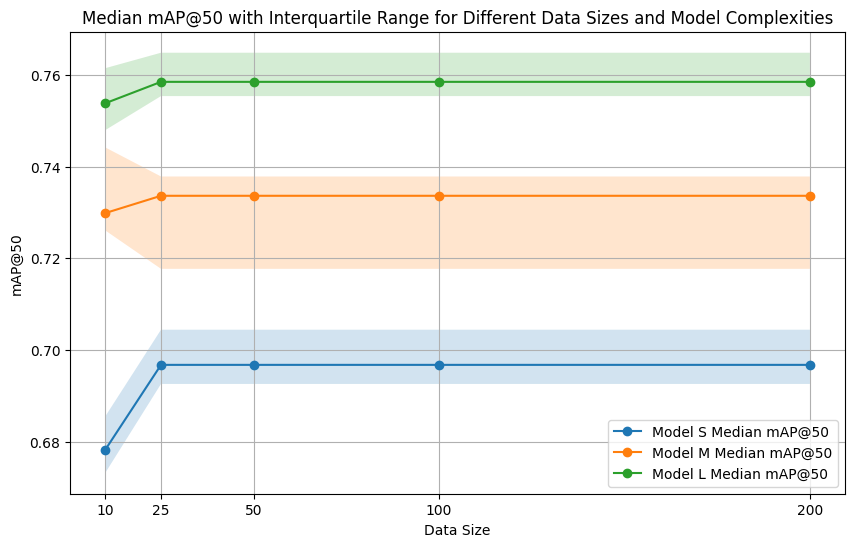

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the actual evaluation data in these variables
# Replace these lines with your actual evaluation data
evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    median_map50 = np.median(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'median': median_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the median values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    median_values = [evaluation_statistics[key]['median'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the median line
    ax.plot(data_sizes, median_values, marker='o', label=f'Model {model_size.upper()} Median mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Median mAP@50 with Interquartile Range for Different Data Sizes and Model Complexities')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks(sorted(set(data_sizes))) # Set x-ticks to unique sorted data sizes
ax.legend()
ax.grid(True)

# Show the plot
plt.show()
